# Distributed policy with comm trained using parallel SAC: split model

In this notebook, we test a variant of [the previous notebook](./Comm-SAC.ipynb), where we split the communication and acceleration models in a way that the transmitted communication *does not* depend on the received message but only on the other observations. 

The agents exchange 1 float and we share part of the reward.

In [1]:
%load_ext autoreload
%autoreload 2

You can skip training and instead load the last trained policy by changing the flag below.

In [2]:
from navground.learning.utils.jupyter import skip_if, run_if

training = True

In [3]:
from navground.learning import DefaultObservationConfig
from navground.learning.parallel_env import make_vec_from_penv
from navground.learning.config.control_action_with_comm import ControlActionWithCommConfig
from navground.learning.examples.pad import get_env, comm, marker, PadReward
from stable_baselines3.common.vec_env import VecMonitor

comm_size = 1
action = ControlActionWithCommConfig(use_acceleration_action=True, max_acceleration=1, 
                                     fix_orientation=True, comm_size=comm_size)
observation = DefaultObservationConfig(flat=False, include_velocity=True, 
                                       include_target_direction=False)
name = "DistributedCommFloatWithRewardSharing"
sensors = [comm(size=comm_size, binarize=False), marker()]
train_env = get_env(action=action, observation=observation, 
                    sensors=sensors, start_in_opposite_sides=False, 
                    reward=PadReward(neighbor_weight=0.5))
train_venv = VecMonitor(make_vec_from_penv(train_env, num_envs=4))
test_env = get_env(action=action, observation=observation, 
                   sensors=sensors, start_in_opposite_sides=True)
test_venv = VecMonitor(make_vec_from_penv(test_env, num_envs=4))

In [4]:
train_venv.observation_space

Dict('neighbor/comm': Box(-1.0, 1.0, (1,), float32), 'pad/x': Box(-1.0, 1.0, (1,), float32), 'ego_velocity': Box(-0.14, 0.14, (1,), float32))

In [5]:
%%skip_if $training

import pathlib, os
from stable_baselines3 import SAC

log = max(pathlib.Path(f'logs/{name}/SAC-SplitModel').glob('*'), key=os.path.getmtime)

In [6]:
%%run_if $training

from stable_baselines3 import SAC
from datetime import datetime as dt
from stable_baselines3.common.logger import configure
from navground.learning.utils.sb3 import callbacks
from navground.learning.scenarios.pad import render_kwargs
from navground.learning.policies.split_sac_policy import SplitSACPolicy

actor_specs = [(1, None, (256, 256)), (1, ('pad/x', 'ego_velocity'), (256, 256))]
model = SAC(SplitSACPolicy, train_venv, verbose=0, policy_kwargs={'actor_specs': actor_specs}, learning_rate=3e-4)
stamp = dt.now().strftime("%Y%m%d_%H%M%S")
log = f"logs/{name}/SAC-SplitModel/{stamp}"
model.set_logger(configure(log, ["csv", "tensorboard"]))
kwargs = render_kwargs(comm=True, low=-1, high=1, binarize=False,
                       color_low=(1, 0, 0), color_high=(0, 1, 0))
cbs = callbacks(venv=test_venv, best_model_save_path=log, 
                eval_freq=500, export_to_onnx=True, **kwargs)
log

'logs/DistributedCommFloatWithRewardSharing/SAC-SplitModel/20250521_150232'

In [7]:
%%run_if $training

model.learn(total_timesteps=500_000,reset_num_timesteps=False, 
            log_interval=10, callback=cbs)
model.num_timesteps

  0%|          | 0/500000 [00:00<?, ?it/s]

500000

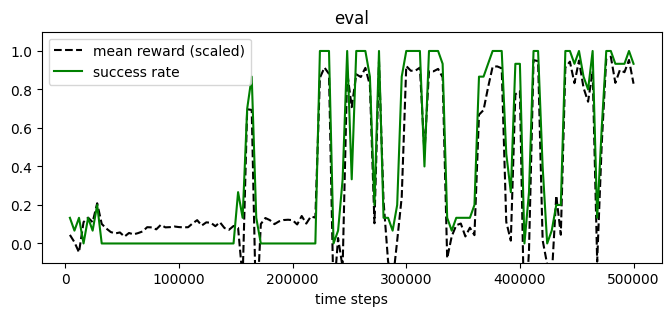

In [8]:
from navground.learning.utils.sb3 import plot_eval_logs

plot_eval_logs(log, reward_low=-200, reward_high=0, success=True, figsize=(8, 3))

In [9]:
from stable_baselines3.common.evaluation import evaluate_policy

best_model = SAC.load(f'{log}/best_model')
evaluate_policy(best_model.policy, test_venv, n_eval_episodes=100)

(-17.000116, 52.541203)

In [15]:
from navground.learning.evaluation.video import display_episode_video

display_episode_video(test_env, policy=best_model.policy, factor=4, seed=1, **kwargs)

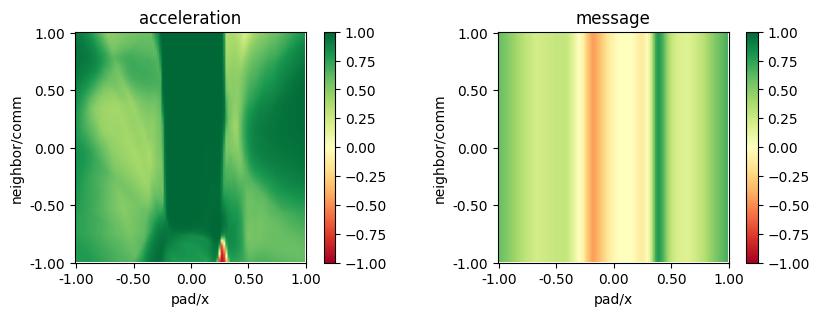

In [16]:
from navground.learning.utils.plot import plot_policy

plot_policy(best_model.policy, 
            variable={'pad/x': (-1, 1), 'neighbor/comm': (-1, 1)},
            fix={'ego_velocity': 0.1},
            actions={0: 'acceleration', 1: 'message'}, 
            width=5, height=3)

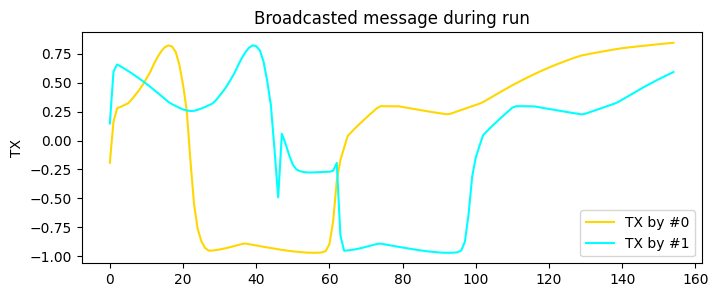

In [17]:
from navground.learning.evaluation.experiment import make_experiment_with_env
from navground.learning.probes.comm import CommProbe
from matplotlib import pyplot as plt
import numpy as np

exp = make_experiment_with_env(test_env, policy=best_model.policy)
exp.add_record_probe('tx', CommProbe)
run = exp.run_once(seed=1)
plt.figure(figsize=(8, 3))
for i, color in enumerate(('gold', 'cyan')):
    plt.plot(np.asarray(run.records['tx'])[:, i, 0], color=color, label=f"TX by #{i}")
plt.legend()
plt.ylabel("TX")
plt.title("Broadcasted message during run");

## Alternate Action and Communication training

In [18]:
%%skip_if $training

import pathlib, os
from stable_baselines3 import SAC

log = max(pathlib.Path(f'logs/{name}/SAC-SplitModelAlternate').glob('*'), key=os.path.getmtime)

In [19]:
%%run_if $training

from navground.learning.policies.split_sac_policy import AlternateActorCallback

actor_specs = [(1, None, (256, 256)), (1, ('pad/x', 'ego_velocity'), (256, 256))]
model_alt = SAC(SplitSACPolicy, train_venv, verbose=0, 
                policy_kwargs={'actor_specs': actor_specs}, learning_rate=3e-4)
stamp = dt.now().strftime("%Y%m%d_%H%M%S")
log_alt = f"logs/{name}/SAC-SplitModelAlternate/{stamp}"
model_alt.set_logger(configure(log_alt, ["csv", "tensorboard"]))
cbs = callbacks(venv=test_venv, best_model_save_path=log_alt, 
                eval_freq=500, export_to_onnx=True, **kwargs)
cbs.append(AlternateActorCallback([(20_000, 1e-4), (20_000, 5e-4)], exclusive=True))
log_alt

'logs/DistributedCommFloatWithRewardSharing/SAC-SplitModelAlternate/20250521_152203'

In [20]:
%%run_if $training

model_alt.learn(total_timesteps=500_000,reset_num_timesteps=False, 
                log_interval=10, callback=cbs)
model_alt.num_timesteps 

  0%|          | 0/500000 [00:00<?, ?it/s]

500000

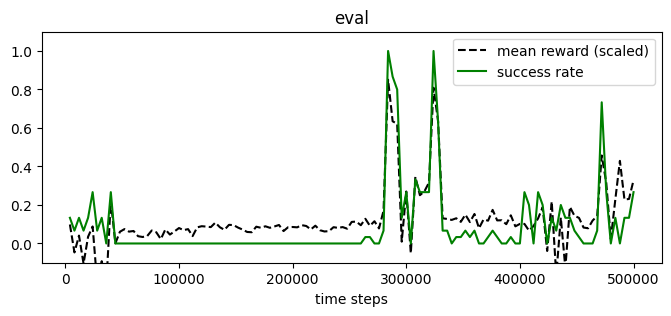

In [21]:
plot_eval_logs(log_alt, reward_low=-200, reward_high=0, success=True, figsize=(8, 3))

In [23]:
# NOTE: cannot load the best model as it does not save all parameters
from navground.learning.onnx import OnnxPolicy

best_policy_alt = OnnxPolicy(f'{log_alt}/best_policy.onnx')
evaluate_policy(best_policy_alt, test_venv, n_eval_episodes=100)

(-66.98785, 100.88285)

In [24]:
display_episode_video(test_env, policy=best_policy_alt, factor=4, seed=1, **kwargs)

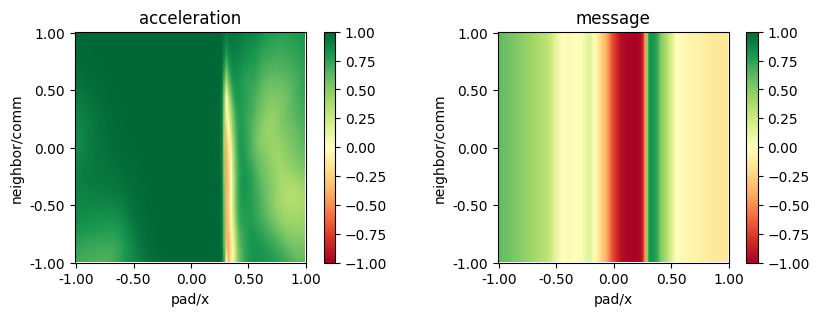

In [25]:
plot_policy(best_policy_alt, 
            variable={'pad/x': (-1, 1), 'neighbor/comm': (-1, 1)},
            fix={'ego_velocity': 0.1},
            actions={0: 'acceleration', 1: 'message'}, 
            width=5, height=3)

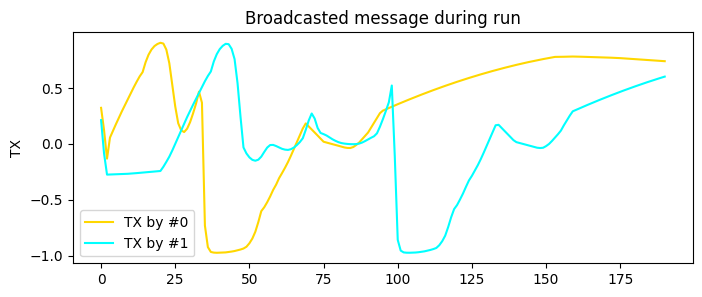

In [26]:
exp = make_experiment_with_env(test_env, policy=best_policy_alt)
exp.add_record_probe('tx', CommProbe)
run = exp.run_once(seed=1)
plt.figure(figsize=(8, 3))
for i, color in enumerate(('gold', 'cyan')):
    plt.plot(np.asarray(run.records['tx'])[:, i, 0], color=color, label=f"TX by #{i}")
plt.legend()
plt.ylabel("TX")
plt.title("Broadcasted message during run");